In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage.morphology import binary_opening, binary_closing, binary_hit_or_miss
from scipy.ndimage import label, find_objects
import matplotlib
import time
import sys
from skimage.measure import label, regionprops

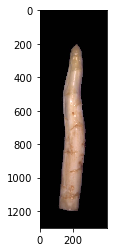

In [193]:
img = plt.imread("C:/Users/Sophia/Documents/GitHub/asparagus/rust_selected/new_prepro/7_2.jpg")
plt.imshow(img)

In [194]:
# to get the mask of the image with which the background was removed, use the functions from the preprocessor
def mask_img(img):
    """
    Finds asparagus in an image and returns a mask that is 1 for every pixel which belongs
    to an asparagus piece and 0 everywhere else. 
    
    img = the image after running segmentation based on color
    
    returns: mask as described above
    """
    img = np.array(img)

    def binarize(img, thres):
        res = np.sum(img,axis=2) > thres
        return res.astype(int)

    bin_img = binarize(img, 10)
    
    def find_largest_region(binary_img):
        """
        Finds the largest continuous region in a binary image
        (which hopefully is the asparagus piece)
        
        binary_img = a binary image with patches of different sizes
        
        returns: essentially a mask
        """
        labeled_img = label(bin_img)
        props = regionprops(labeled_img)
        maxi = 0
        maxval = 0
        for i, prop in enumerate(props):
            if prop.area > maxval:
                maxi = i
                maxval = prop.area

        proppy = props[maxi]
        coords = proppy.coords # 2d np array
        empty = np.zeros(bin_img.shape)
        for i in range(len(coords)):
            empty[coords[i,0], coords[i,1]] = 1
        return empty
    
    # find largest region, open the image, and find the largest region
    # once again, because the opening might just have created a small
    # "island" instead of completely removing the noise
    empty = find_largest_region(bin_img)
    empty = binary_opening(empty, structure=np.ones((21,21)))
    empty = find_largest_region(empty)
    
    return empty
def cut_background(img, background_min_hue, background_max_hue, background_brightness):
    """ Initiates masking in the hsv space.

    Cuts out background with specific hue values.

    Args:
        img (Image): Image as numpy array
        background_max_hue (float): [0-255] 
        background_min_hue (float): [0-255] 
        background_brightness (float): [0-255] 

    Returns:
        Image: Image without background 
    """
    
    # Open Image
    raw = np.array(img)
    # remove alpha-channel (only if its RGBA)
    raw = raw[:,:,0:3]
    # transform to HSV color space
    hsv = matplotlib.colors.rgb_to_hsv(raw)
    # Mask all blue hues (background)
    mask = np.logical_and(hsv[:,:,0] > background_min_hue , hsv[:,:,0] < background_max_hue)
    
    # Mask out values that are not bright enough
    mask = np.logical_or(hsv[:,:,2] < background_brightness, mask)
    #Use binary hit and miss to remove potentially remaining isolated pixels:
    m = np.logical_not(mask)

    change = 1
    while(change > 0):
        a = binary_hit_or_miss(m, [[ 0, -1,  0]]) + binary_hit_or_miss(m, np.array([[ 0, -1,  0]]).T)
        m[a] = False
        change = np.sum(a)
        # plt.imshow(a) # printf(changes)
    
    mask = np.logical_not(m)
    raw[:,:,0][mask] = 0
    raw[:,:,1][mask] = 0
    raw[:,:,2][mask] = 0


    return mask, raw

In [195]:
# get the mask to determine where the asparagus is located
mask, color_seg_result = cut_background(img, 0.4, 0.8, 50)
mask = mask_img(color_seg_result)
# turn our mask into a color mask
cmask = np.stack([mask, mask, mask], axis=2)

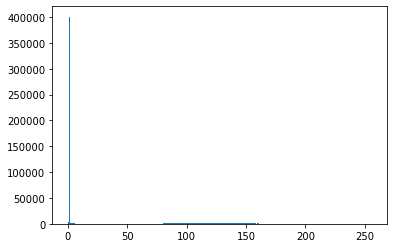

In [196]:
hist,bins = np.histogram(img.ravel(),256,[0,256])
plt.hist(img[:,:,2].ravel(),256,[0,256]); plt.show()

In [197]:
# set the lower und upper bound for "rusty-colours"
# TODO: find better upper and lower bounds
lower = np.array([50,42,31])
upper = np.array([220,220,55])

In [198]:
import cv2
rust_mask = cv2.inRange(img, lower, upper)
output = cv2.bitwise_and(img, img, mask = rust_mask)

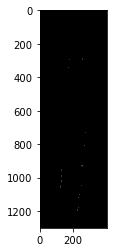

In [199]:
plt.imshow(output)

In [200]:
count = np.count_nonzero(output)
print(count)

2448


15957


1560000